In [9]:
!unzip "PlantVillage.zip" -d "PlantVillage/"

Streaming output truncated to the last 5000 lines.
  inflating: PlantVillage/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite/fee1de1c-c369-4535-baec-d6104df9a05d___Com.G_SpM_FL 9396.JPG  
  inflating: PlantVillage/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite/ff0f33d2-9e9f-4b74-861d-a7e0fdf8d248___Com.G_SpM_FL 8511.JPG  
  inflating: PlantVillage/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite/ff146f2c-dbb7-4da0-aa98-a36351435489___Com.G_SpM_FL 9654.JPG  
  inflating: PlantVillage/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite/ff20d775-59a6-437c-9039-f72d07aa4484___Com.G_SpM_FL 8524.JPG  
  inflating: PlantVillage/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite/ff6346ca-227b-4cb4-a350-0941048744fa___Com.G_SpM_FL 9338.JPG  
  inflating: PlantVillage/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite/ff9a52b5-b200-4f23-9e0d-629b1a0e89db___Com.G_SpM_FL 8634.JPG  
  inflating: PlantVillage/PlantVillage/Tomato_Spider_mites_Two_spotted_sp

Dependencies

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


Data Preprocessing & Augmentation

In [ ]:
data_dir = 'PlantVillage/PlantVillage'  # Root dir
batch_size = 32
image_size = 224
test_split = 0.2  # 20% testset
val_split = 0.2  # 20% validation set

# Data preprocessing & augmentation
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes
print(f"Detected Classes: {class_names}")

# Split train / val
val_size = int(val_split * len(full_dataset))
test_size = int(test_split * len(full_dataset))
train_size = len(full_dataset) - val_size - test_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(86))

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


Detected Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


Initiallize Model

In [ ]:
# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-train model
model = models.mobilenet_v2(pretrained=True)

# replace classifier head
num_classes = len(class_names)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# load to device
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 241MB/s]


In [ ]:
# Define Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

Model Training

In [18]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    loss = running_loss / total
    acc = correct / total
    return loss, acc


In [19]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    loss = running_loss / total
    acc = correct / total
    return loss, acc


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f}, Acc: {val_acc:.4f}")
    print(f"Test Loss:  {test_loss:.4f}, Acc: {test_acc:.4f}")
    print()


Epoch 1/10
Train Loss: 0.2800, Acc: 0.9139
Val Loss:   0.0872, Acc: 0.9721
Test Loss:  0.0935, Acc: 0.9704

Epoch 2/10
Train Loss: 0.1084, Acc: 0.9636
Val Loss:   0.0925, Acc: 0.9700
Test Loss:  0.0942, Acc: 0.9690

Epoch 3/10
Train Loss: 0.0740, Acc: 0.9773
Val Loss:   0.0775, Acc: 0.9782
Test Loss:  0.0748, Acc: 0.9758

Epoch 4/10
Train Loss: 0.0673, Acc: 0.9787
Val Loss:   0.0589, Acc: 0.9792
Test Loss:  0.0582, Acc: 0.9833

Epoch 5/10
Train Loss: 0.0619, Acc: 0.9790
Val Loss:   0.0468, Acc: 0.9833
Test Loss:  0.0559, Acc: 0.9826

Epoch 6/10
Train Loss: 0.0468, Acc: 0.9843
Val Loss:   0.0522, Acc: 0.9857
Test Loss:  0.0477, Acc: 0.9859

Epoch 7/10
Train Loss: 0.0451, Acc: 0.9860
Val Loss:   0.0457, Acc: 0.9869
Test Loss:  0.0459, Acc: 0.9872

Epoch 8/10
Train Loss: 0.0344, Acc: 0.9884
Val Loss:   0.0283, Acc: 0.9925
Test Loss:  0.0408, Acc: 0.9886

Epoch 9/10
Train Loss: 0.0331, Acc: 0.9898
Val Loss:   0.0413, Acc: 0.9855
Test Loss:  0.0446, Acc: 0.9872

Epoch 10/10
Train Loss: 0.04

Save Model Parameters

In [ ]:
torch.save(model.state_dict(), 'agricsan_weights.pth')

Load Model Parameters

In [20]:
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model.load_state_dict(torch.load('agricsan_weights.pth', map_location=device))
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Testing

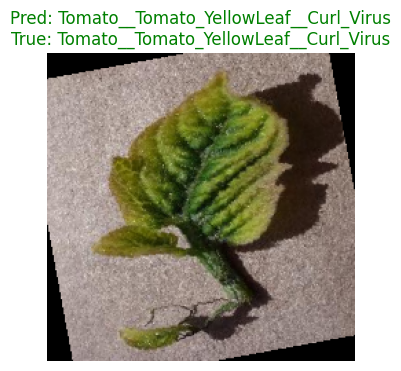

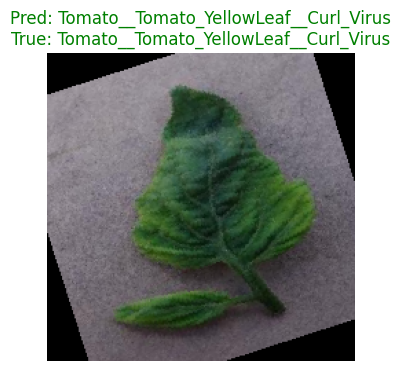

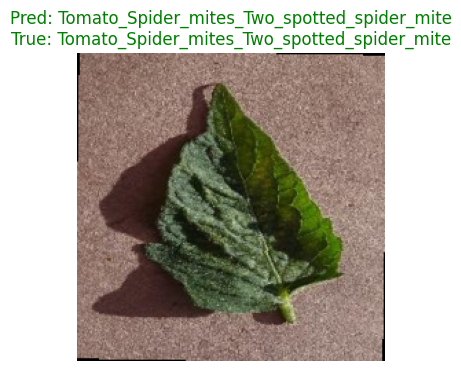

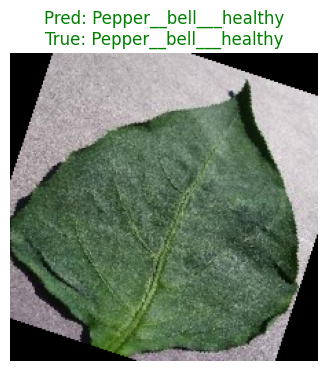

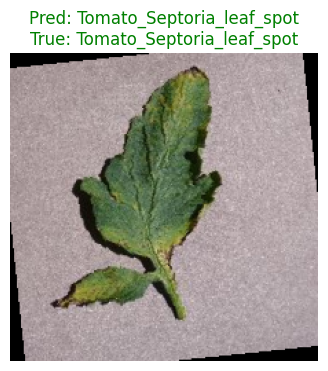

In [ ]:
def imshow(img, title=None):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # 去标准化
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Random Sampling
model = model.to(device)
model.eval()
images, labels = next(iter(test_loader))  # 抽一批
images, labels = images.to(device), labels.to(device)

# Prediction
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Visualize 5 images
for i in range(5):
    plt.figure(figsize=(4, 4))
    correct = preds[i] == labels[i]
    color = 'green' if correct else 'red'
    title = f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}"
    imshow(images[i], title=title)
    plt.title(title, color=color)
    plt.show()


<Figure size 1000x1000 with 0 Axes>

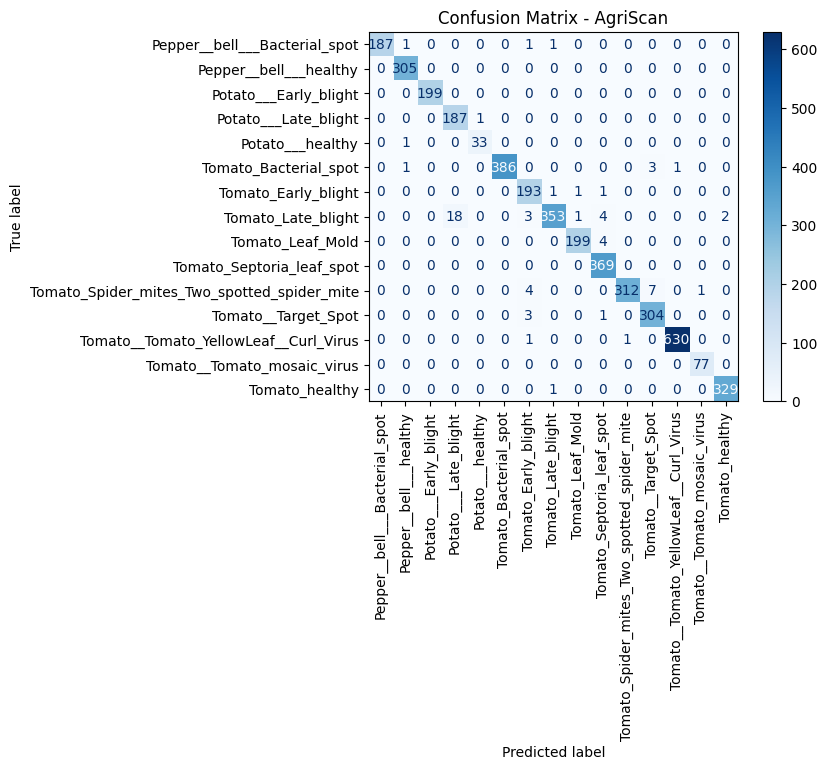

In [ ]:
model.eval()
model = model.to(device)

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Visualization
plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.title("Confusion Matrix - AgriScan")
plt.grid(False)
plt.show()


Model Deployment

In [ ]:
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import models, transforms
import matplotlib.pyplot as plt

def load_model(model_path, num_classes, device):
    model = models.mobilenet_v2(pretrained=False)
    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

def predict_image(image_path, model, class_names, device):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        pred_label = class_names[pred_idx]
        pred_prob = probs[0][pred_idx].item()

    # Visualization
    plt.imshow(image)
    plt.title(f"{pred_label} ({pred_prob:.1%})")
    plt.axis('off')
    plt.show()

    return pred_label, pred_prob


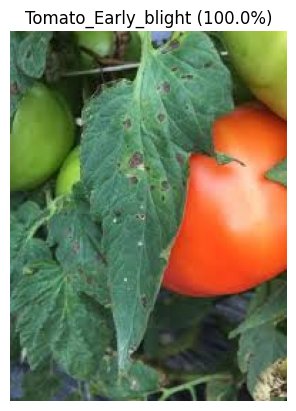

✅ Prediction: Tomato_Early_blight (99.99%)
Type: Tomato
Issue: Early blight


In [ ]:
model_path = 'Model/agricsan_weights.pth'
image_path = 'Show Case/Tomato_Early_blight_test_1.jpg'  # test image dir
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Labels from ImageFolder
class_names = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']

# Load model
model = load_model(model_path, num_classes=len(class_names), device=device)

# Predict an image
label, prob = predict_image(image_path, model, class_names, device)
print(f"✅ Prediction: {label} ({prob:.2%})")

type=label.split('_')[0]
issue=" ".join(label.split('_')[1:])
print(f"Type: {type}")
print(f"Issue: {issue}")
